In [1]:
from matplotlib import pyplot as plt
import os
import numpy as np
%matplotlib inline
from matplotlib.offsetbox import AnchoredText
from DSOhelper import addsubfiglabels,get_oscilloscope_data,getvoltage,plot_scope_data,subplot_scope_data
from statsmodels.tsa import stattools #conda install -c conda-forge statsmodels
from scipy import signal
from scipy.signal import find_peaks
from time import time as t

## determine the mean height of peaks vs overvoltage

In [2]:
datafolder = "vary_led_1562/"
files = sorted([f for f in os.listdir(datafolder) if f[:4]=="temp"])
file=files[0]
len(files),files[::len(files)-1]

(10000, ['temp0000000.CSV', 'temp0009999.CSV'])

In [3]:
dataseq,headers=get_oscilloscope_data(f"{datafolder}{file}")

In [4]:
headers

{1: {'Memory Length': 10000.0,
  'IntpDistance': 0.0,
  'Trigger Address': 5159.0,
  'Trigger Level': 0.3,
  'Source': 'CH1',
  'Vertical Units': 'V',
  'Vertical Units Div': 0.0,
  'Vertical Units Extend Div': 16.0,
  'Label': '',
  'Probe Type': 0.0,
  'Probe Ratio': 10.0,
  'Vertical Scale': 0.5,
  'Vertical Position': -1.78,
  'Horizontal Units': 'S',
  'Horizontal Scale': 2e-05,
  'Horizontal Position': -3.2e-06,
  'Horizontal Mode': 'Main',
  'SincET Mode': 'Real Time',
  'Sampling Period': 2e-08,
  'Horizontal Old Scale': 2e-05,
  'Horizontal Old Position': -3.2e-06,
  'Firmware': 'V1.23',
  'Mode': 'Fast'},
 2: {'Memory Length': 10000.0,
  'IntpDistance': 0.0,
  'Trigger Address': 5159.0,
  'Trigger Level': 0.3,
  'Source': 'CH2',
  'Vertical Units': 'V',
  'Vertical Units Div': 0.0,
  'Vertical Units Extend Div': 16.0,
  'Label': '',
  'Probe Type': 0.0,
  'Probe Ratio': 1.0,
  'Vertical Scale': 0.2,
  'Vertical Position': -2.24,
  'Horizontal Units': 'S',
  'Horizontal Scale'

In [5]:
headers[1]["Sampling Period"],headers[1]["Vertical Scale"]

(2e-08, 0.5)

### plotting a subset of data for sanity check

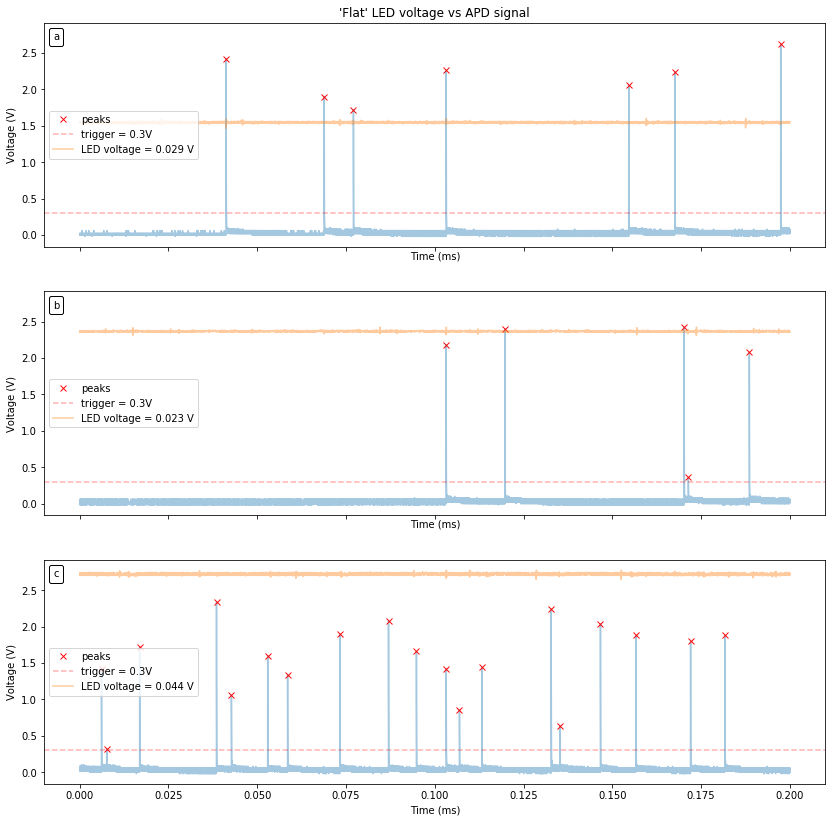

In [6]:
zeroOverVoltage = 139.3
CH=1
fig,axx = plt.subplots(3,1,figsize=(14,14),sharey=True,sharex=True)
for i,file,ax in zip(range(len(axx)),['temp0000205.CSV','temp0005505.CSV','temp0009505.CSV'],axx):
    dataseq,headers=get_oscilloscope_data(f"{datafolder}{file}")
    xscale=1e3
    subplot_scope_data(dataseq,headers,ax,alpha=0.4,xscale=xscale) 
    peak_x , peak_heights = find_peaks(dataseq[CH],height=15)
    ax.plot(peak_x*headers[CH]["Sampling Period"]*xscale,getvoltage(peak_heights["peak_heights"],headers[CH]),"x",c="r",alpha=0.96,label="peaks")
    ax.axhline(headers[CH]["Trigger Level"],c="r",ls="--",alpha=0.3,label=f"trigger = {headers[CH]['Trigger Level']}V")
    subplot_scope_data(dataseq,headers,ax,CH=2,alpha=0.4,xscale=xscale,label=f"LED voltage = {np.mean(getvoltage(dataseq[CH] ,headers[CH])):.3f} V")
    ax.legend(loc="center left")
    ax.set_ylabel("Voltage (V)")
    ax.set_xlabel("Time (ms)")
    if i ==0:
        ax.set_title("'Flat' LED voltage vs APD signal")
addsubfiglabels(axx)
plt.savefig("results08_01_flatLEDvoltage.png")

In [7]:
%%time
average_led_voltage=[]
average_peak_counts = []
for file in files[::]:
    dataseq,headers=get_oscilloscope_data(f"{datafolder}{file}")
    average_led_voltage.append(np.mean(getvoltage(dataseq[2],headers[2])))
    peak_x , peak_heights = find_peaks(dataseq[1],height=15)
    average_peak_counts.append(len(peak_x))

CPU times: user 2min 7s, sys: 2.72 s, total: 2min 10s
Wall time: 2min 10s


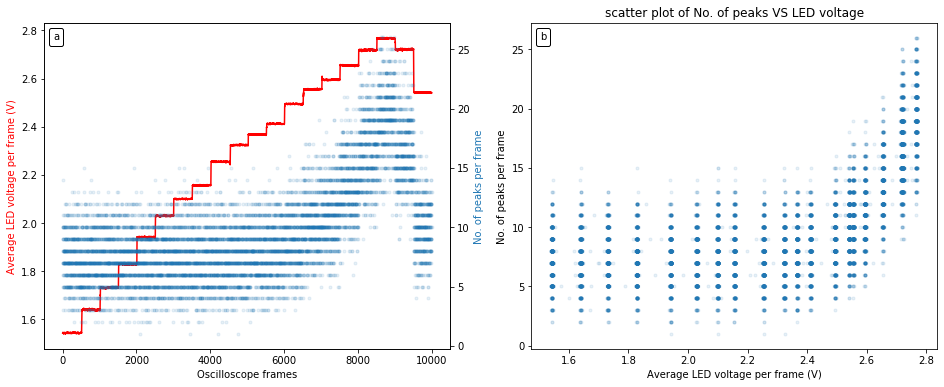

In [8]:
fig,axx = plt.subplots(1,2,figsize=(16,6))
ax=axx[0]
ax.plot(average_led_voltage,color="red")
##ax.set_title("LED voltage")
ax.set_ylabel("Average LED voltage per frame (V)",color="red")
ax.set_xlabel("Oscilloscope frames")
ax=axx[0].twinx()
ax.plot(average_peak_counts,".",alpha=0.1)
#ax.set_title("counts per frame")
ax.set_ylabel("No. of peaks per frame",color="tab:blue")

ax=axx[1]
ax.scatter(average_led_voltage,average_peak_counts,marker=".",alpha=0.1)
ax.set_xlabel("Average LED voltage per frame (V)")
ax.set_ylabel("No. of peaks per frame")
ax.set_title("scatter plot of No. of peaks VS LED voltage")
addsubfiglabels(axx)
plt.savefig("results08_02_overviewplot_with_transients.png")

## G2 plot, are photons from led coherent?

$$g^{(2)}(\tau) = \frac{\langle I(t) I(t+\tau) \rangle}{\langle I(t) \rangle ^2}$$

In [9]:
def g(tau,inten,averaged_over=9000):
    denominator = np.mean([inten[:averaged_over],inten[tau:tau+averaged_over]])**2
    return np.mean( [inten[i] * inten[i+tau] for i in range(averaged_over) ])/denominator

In [10]:
voltages = getvoltage(dataseq[1],headers[1])
t0 = t()
g2_custom = [g(tau,voltages) for tau in range(1000)]
t1 = t()-t0
t0 = t()
g2_stattool = stattools.acf(voltages,nlags=1000)
t2 = t()-t0

CPU times: user 966 ms, sys: 12 ms, total: 978 ms
Wall time: 395 ms


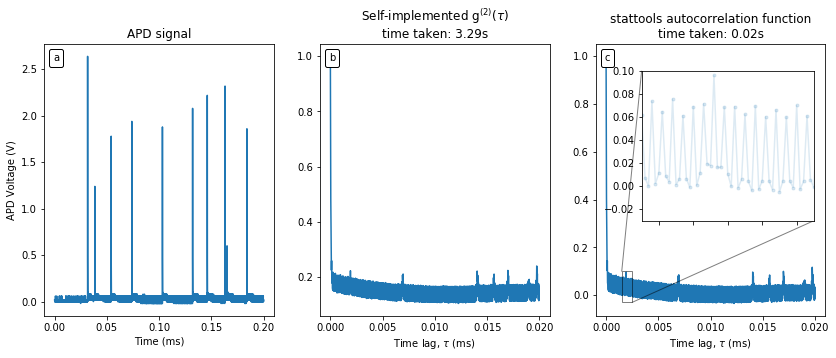

In [11]:
%%time
#voltages = np.sin(5*np.linspace(0,2*np.pi,10000))+10
fig,axx=plt.subplots(1,3,figsize=(14,5))
ax = axx[0]
ax.plot(np.arange(len(voltages))*headers[1]["Sampling Period"]*xscale,voltages)
ax.set_xlabel(r"Time (ms)")
ax.set_ylabel("APD Voltage (V)")
ax.set_title("APD signal")
ax = axx[1]
ax.plot(np.arange(len(g2_custom))*headers[1]["Sampling Period"]*xscale,g2_custom/np.max(g2_custom))
ax.set_title(r"Self-implemented g$^{(2)}(\tau)$"+f"\ntime taken: {t1:.2f}s")
ax.set_xlabel(r"Time lag, $\tau$ (ms)")
ax = axx[2]
ax.plot(np.arange(len(g2_stattool))*headers[1]["Sampling Period"]*xscale,g2_stattool)
ax.set_title(r"stattools autocorrelation function"+f"\ntime taken: {t2:.2f}s")
ax.set_xlabel(r"Time lag, $\tau$ (ms)")
x1, x2, y1, y2 = 0.0015, 0.0025, -0.03, 0.10
axins = ax.inset_axes([0.20, 0.35, 0.75, 0.55])
axins.plot(np.arange(len(g2_stattool))*headers[1]["Sampling Period"]*xscale,g2_stattool,".-",alpha=0.15)

axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.set_xticklabels([]) 
addsubfiglabels(axx,loc="upper left")
ax.indicate_inset_zoom(axins, edgecolor="black")
plt.savefig("results08_03_compare_implementation.png")

In [12]:
voltages = getvoltage(dataseq[1],headers[1])
voltages=np.where(voltages<0.2,0,voltages)
t0 = t()
g2_custom = [g(tau,voltages) for tau in range(1000)]
t1 = t()-t0
t0 = t()
g2_stattool = stattools.acf(voltages,nlags=1000)
t2 = t()-t0

CPU times: user 858 ms, sys: 7.96 ms, total: 866 ms
Wall time: 287 ms


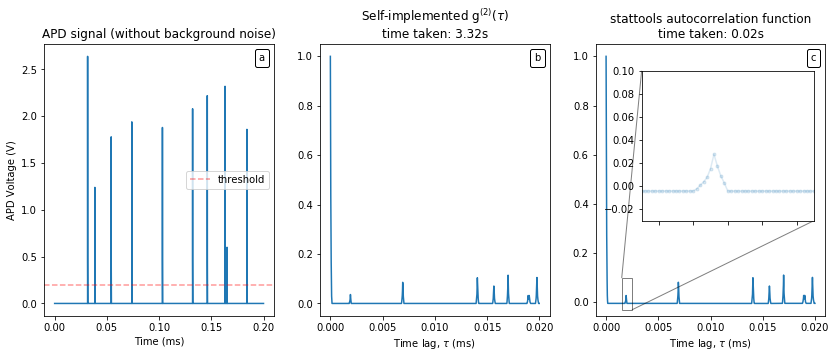

In [13]:
%%time
#voltages = np.sin(5*np.linspace(0,2*np.pi,10000))+10
fig,axx=plt.subplots(1,3,figsize=(14,5))
ax = axx[0]
ax.plot(np.arange(len(voltages))*headers[1]["Sampling Period"]*xscale,voltages)
ax.set_xlabel(r"Time (ms)")
ax.set_ylabel("APD Voltage (V)")
ax.set_title("APD signal (without background noise)")
ax.axhline(0.2,alpha=0.4,ls="--",color="red",label="threshold")
ax.legend(loc="right")
ax = axx[1]
ax.plot(np.arange(len(g2_custom))*headers[1]["Sampling Period"]*xscale,g2_custom/np.max(g2_custom))
ax.set_title(r"Self-implemented g$^{(2)}(\tau)$"+f"\ntime taken: {t1:.2f}s")
ax.set_xlabel(r"Time lag, $\tau$ (ms)")
ax = axx[2]
ax.plot(np.arange(len(g2_stattool))*headers[1]["Sampling Period"]*xscale,g2_stattool)
ax.set_title(r"stattools autocorrelation function"+f"\ntime taken: {t2:.2f}s")
ax.set_xlabel(r"Time lag, $\tau$ (ms)")
x1, x2, y1, y2 = 0.0015, 0.0025, -0.03, 0.10
axins = ax.inset_axes([0.20, 0.35, 0.75, 0.55])
axins.plot(np.arange(len(g2_stattool))*headers[1]["Sampling Period"]*xscale,g2_stattool,".-",alpha=0.15)

axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.set_xticklabels([]) 
addsubfiglabels(axx,loc="upper right")
ax.indicate_inset_zoom(axins, edgecolor="black")
plt.savefig("results08_04_thresholding.png")

In [31]:
from multiprocessing import Pool

def f(file):
    dataseq,headers=get_oscilloscope_data(f"{datafolder}{file}")
    voltages = getvoltage(dataseq[1],headers[1])
    voltages = np.where(voltages<0.2,0,voltages)
    #g2_stattool = stattools.acf(voltages,nlags=2000) 
    # g2_arr_custom.append( [g(tau,voltages) for tau in range(500)] )
    return [g(tau,voltages) for tau in range(500)]

In [32]:
frame_list = [1050,6550,8050]

In [33]:
%%time
frame_list_dict = dict()
for frame_i in frame_list:
    print(frame_i,end="  ")
    with Pool(8) as p:
        vals = p.map(f, [file for file in files[frame_i:frame_i+400]])
    file=f'temp000{frame_i+10:04d}.CSV'
    dataseq,headers=get_oscilloscope_data(f"{datafolder}{file}") 
    led_volt = getvoltage(dataseq[2],headers[2])
    frame_list_dict[frame_i] = (vals,dataseq,headers,led_volt)

1050  6550  8050  CPU times: user 751 ms, sys: 782 ms, total: 1.53 s
Wall time: 10min 16s


CPU times: user 1.87 s, sys: 0 ns, total: 1.87 s
Wall time: 1.87 s


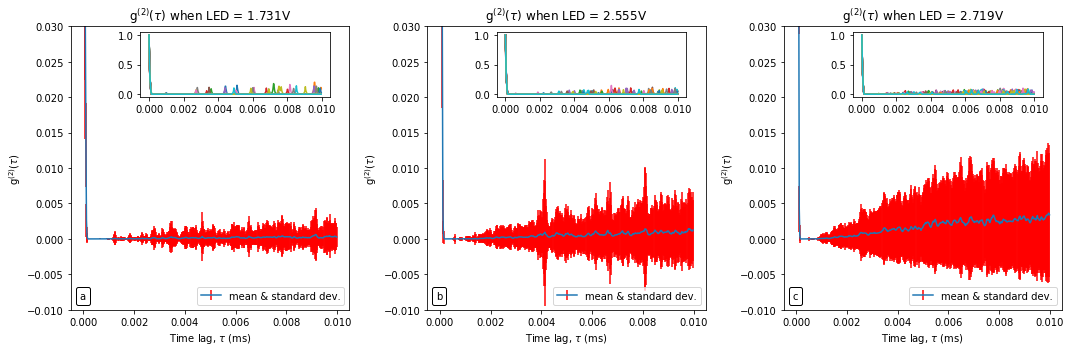

In [45]:
%%time
fig,axx = plt.subplots(1,3,figsize=(15,5)) 
for ax, frame_i in zip(axx,frame_list):
    (vals,dataseq,headers,led_volt) = frame_list_dict[frame_i]

    ax.set_title(r"g$^{(2)}(\tau)$ when LED = "+f"{np.mean(led_volt):.3f}V")
    ax.set_ylabel(r"g$^{(2)}(\tau)$")
    ax.set_xlabel(r"Time lag, $\tau$ (ms)")
    ax.errorbar(x=np.arange(500)*headers[1]["Sampling Period"]*xscale,
                y=np.mean( np.asarray(vals),axis=0 )/np.max(np.asarray(vals)),
                yerr=np.std( np.asarray(vals),axis=0 )/np.max(vals),
                ecolor = 'red',color="tab:blue",label="mean & standard dev.")
    ax.legend(loc="lower right")
    ax.set_ylim(-0.01,0.03)
    axins = ax.inset_axes([0.25, 0.75, 0.68, 0.23])
    for ii in range(30):
        axins.plot(np.arange(500)*headers[1]["Sampling Period"]*xscale,
                   np.asarray(vals)[ii:ii+1].T/np.max(vals[ii:ii+1],axis=1))
    
addsubfiglabels(axx,loc="lower left")
plt.tight_layout()
plt.savefig("results08_05_g2_different_led_voltage.png")

In [48]:
%%time
frame_list_dict = dict()
for frame_i in list(range(50,10000,500)):
    print(frame_i,end="  ")
    with Pool(8) as p:
        vals = p.map(f, [file for file in files[frame_i:frame_i+400]])
    file=f'temp000{frame_i+10:04d}.CSV'
    dataseq,headers=get_oscilloscope_data(f"{datafolder}{file}") 
    led_volt = getvoltage(dataseq[2],headers[2])
    frame_list_dict[frame_i] = (vals,dataseq,headers,led_volt)

50  550  1050  1550  2050  2550  3050  3550  4050  4550  5050  5550  6050  6550  7050  7550  8050  8550  9050  9550  CPU times: user 4.63 s, sys: 6.71 s, total: 11.3 s
Wall time: 1h 8min 38s


In [18]:
#https://www.kth.se/social/files/5cb1833856be5bf03c8165fa/Lecture%203%20Second-order%20Intensity%20Correlation%20Function.pdf

In [50]:
import pickle

In [51]:
with open("frame_list_dict.pkl","wb") as f:
    pickle.dump(frame_list_dict,f)

In [52]:
with open("frame_list_dict.pkl","rb") as f:
    frame_list_dict2 = pickle.load(f)